In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import scipy.stats as stats
%load_ext rpy2.ipython

##### Load the data
The parameters are stored in the data folder. We load the best model's parameter for each subject. This model is an HDDM with 7 parameters. 
1. z: Starting point
2. t: Non-decision time
3. a: Boundary separation
4. v_intercept: Fixed utility bias
5. v_gain: Utility weight for gain
6. v_loss: Utility weight for loss
7. theta: linear rate of boundary shrinkage

**TODO:** Train the following HDDMs and check which one is better to answer the question (Do we need theta? Do we need different v_gain and v_loss? Do we need the v_intercept?):
- With 6 parameters: z, t, a, v_intercept, v_gain, v_loss
- With 6 parameters: z, t, a, v_intercept, v_gain = v_loss, theta
- With 6 parameters: z, t, a, v_gain, v_loss, theta

Also, could train for more chains and check for convergence. Furthermore, it seems like some parameters are getting stuck at the boundary. Check for that. 

In [27]:
all_params_fit = pd.read_csv("../../data/ddm_fits.csv")[["param_name", "mean", "std", "sub", "condition"]]
# We will include lambda as a parameter, which is the ratio of the drift rate towards gain to the drift rate towards loss
lmbda = {}
lmbda["param_name"] = "lambda"
lmbda["mean"] = np.abs(all_params_fit.query("param_name == 'v_loss'")["mean"].values / all_params_fit.query("param_name == 'v_gain'")["mean"].values)
lmbda["std"] = 0
lmbda["sub"] = all_params_fit.query("param_name == 'v_loss'")["sub"].values
lmbda["condition"] = all_params_fit.query("param_name == 'v_loss'")["condition"].values
lmbda = pd.DataFrame(lmbda)
# all_params_fit = pd.concat([all_params_fit, lmbda])

# Sort the all_params_fit by sub and condition
all_params_fit = all_params_fit.sort_values(by=["sub"])

In [28]:
# make param_name v_loss be negative of the value
all_params_fit.loc[all_params_fit["param_name"] == "v_loss", "mean"] = -all_params_fit.loc[all_params_fit["param_name"] == "v_loss", "mean"]
# same with v_Intercept
all_params_fit.loc[all_params_fit["param_name"] == "v_Intercept", "mean"] = -all_params_fit.loc[all_params_fit["param_name"] == "v_Intercept", "mean"]


I had to remove the outliers, which implies I should probably check for convergence of the parameters. 

In [29]:
for condition in all_params_fit["condition"].unique():
    for param in all_params_fit["param_name"].unique():
        # Filter the dataframe
        mask = (all_params_fit["param_name"] == param) & (all_params_fit["condition"] == condition)
        
        # Compute Q1, Q3, and IQR
        Q1 = all_params_fit.loc[mask, "mean"].quantile(0.25)
        Q3 = all_params_fit.loc[mask, "mean"].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds for outliers
        lower_bound = Q1 - 1.25 * IQR
        upper_bound = Q3 + 1.25 * IQR
        
        # Set outliers to NaN
        all_params_fit.loc[mask & ((all_params_fit["mean"] < lower_bound) | (all_params_fit["mean"] > upper_bound)), "mean"] = np.nan

### Parameter differences between conditions
**Question: How do the parameters differ between conditions?**

Independent t-tests are used to determine if the parameters are statistically different between conditions. We use False Discovery Rate (FDR) to correct for multiple comparisons. 

In [30]:
p_values, t_stats = [], []
for param in all_params_fit["param_name"].unique():
    ttest = stats.ttest_ind(all_params_fit.query(f"param_name == '{param}' & condition == 'equalRange'")["mean"].dropna(), all_params_fit.query(f"param_name == '{param}' & condition == 'equalIndifference'")["mean"].dropna())
    p_values.append(ttest.pvalue)
    t_stats.append(ttest.statistic)

p_values = stats.false_discovery_control(p_values)
for i, param in enumerate(all_params_fit["param_name"].unique()):
    if p_values[i] < 0.05:
        print(param)
        print("t_stats: ", t_stats[i], "p_values: ", p_values[i])
        print()

v_gain
t_stats:  17.310275735249448 p_values:  3.839692409138444e-31

v_loss
t_stats:  3.629810894917824 p_values:  0.0015463998929177894



**Findings:**
- Not statistically different:
    - Boundary separation (a)
    - Non-decision time (t)
    - Starting point (z)
    - Boundary shrinkage (theta)
    - v_intercept
- Statistically different:
    - v_loss (equalRange > equalIndifference, in absolute value)
    - v_gain (equalRange > equalIndifference, in absolute value)

The utility on the gain is much higher in the equalRange condition as compared to the equalIndifference condition. Furthermore, the utility on the loss is slightly higher in the equalRange condition as compared to the equalIndifference condition. Hence, the subjects in the equalRange condition are less loss averse due to the much higher utility on the gain. 

**TODO:** One could fit the PT model and check to predict lambda with v_loss and v_gain and confirm the stated above. 

Just compare loss aversion across conditions. (Not with DDM params)
#### Plotting the parameters

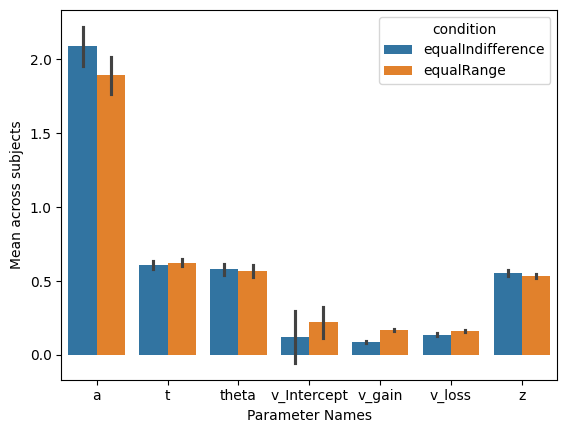

In [31]:
sns.barplot(data=all_params_fit, x="param_name", y="mean", hue="condition", errorbar=('ci', 95))
plt.xlabel("Parameter Names")
plt.ylabel("Mean across subjects")
plt.show()

### Correlation between parameters within condition
**Question: How do the parameters correlate within condition?**

In [32]:
params_fit_col = all_params_fit.pivot(index=["sub", "condition"], columns="param_name", values="mean").reset_index()

Equal Range Condition


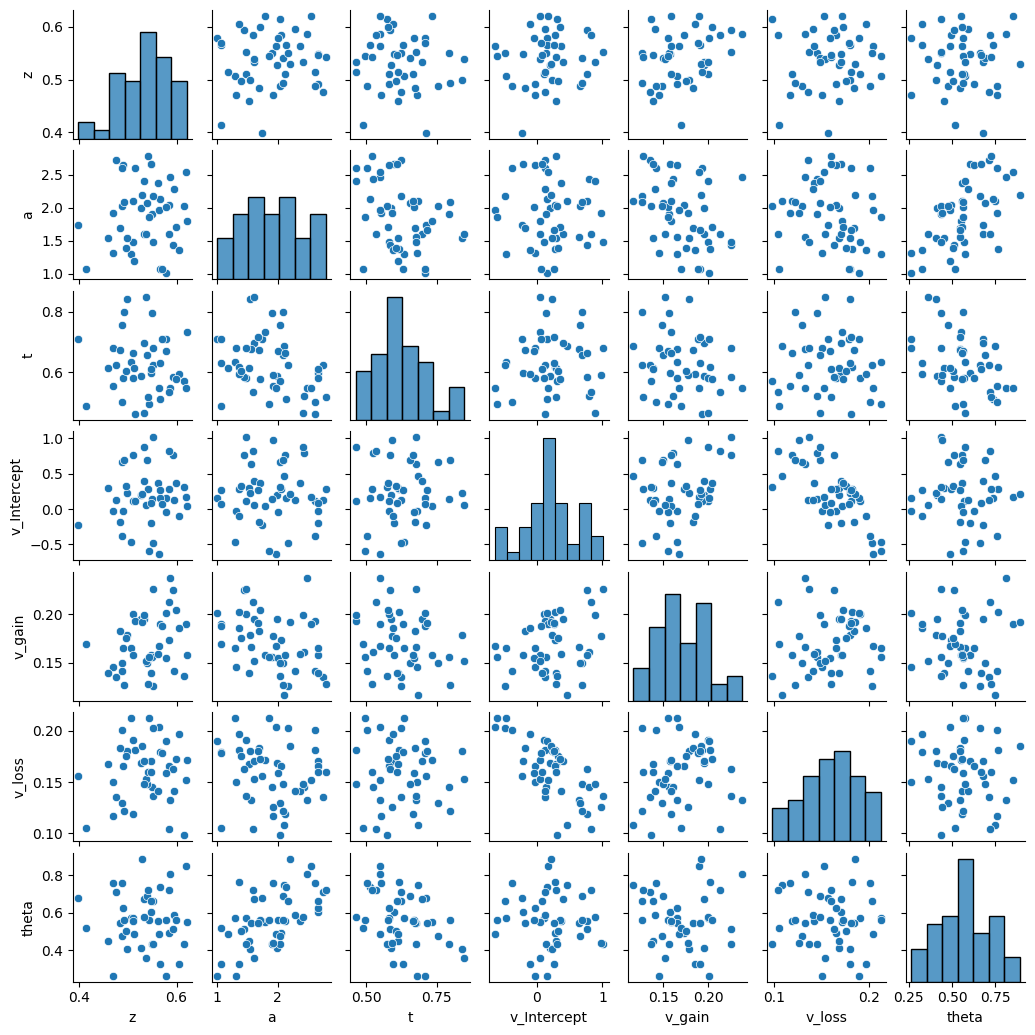

In [38]:
# Create a small figure to put the sns.pairplot in
print("Equal Range Condition")
equalRange_params = params_fit_col.query("condition == 'equalRange'")[["z", "a", "t", "v_Intercept", "v_gain", "v_loss", "theta"]]
sns.pairplot(equalRange_params, height = 1.5, dropna=True)
plt.show()

Equal Indifference Condition


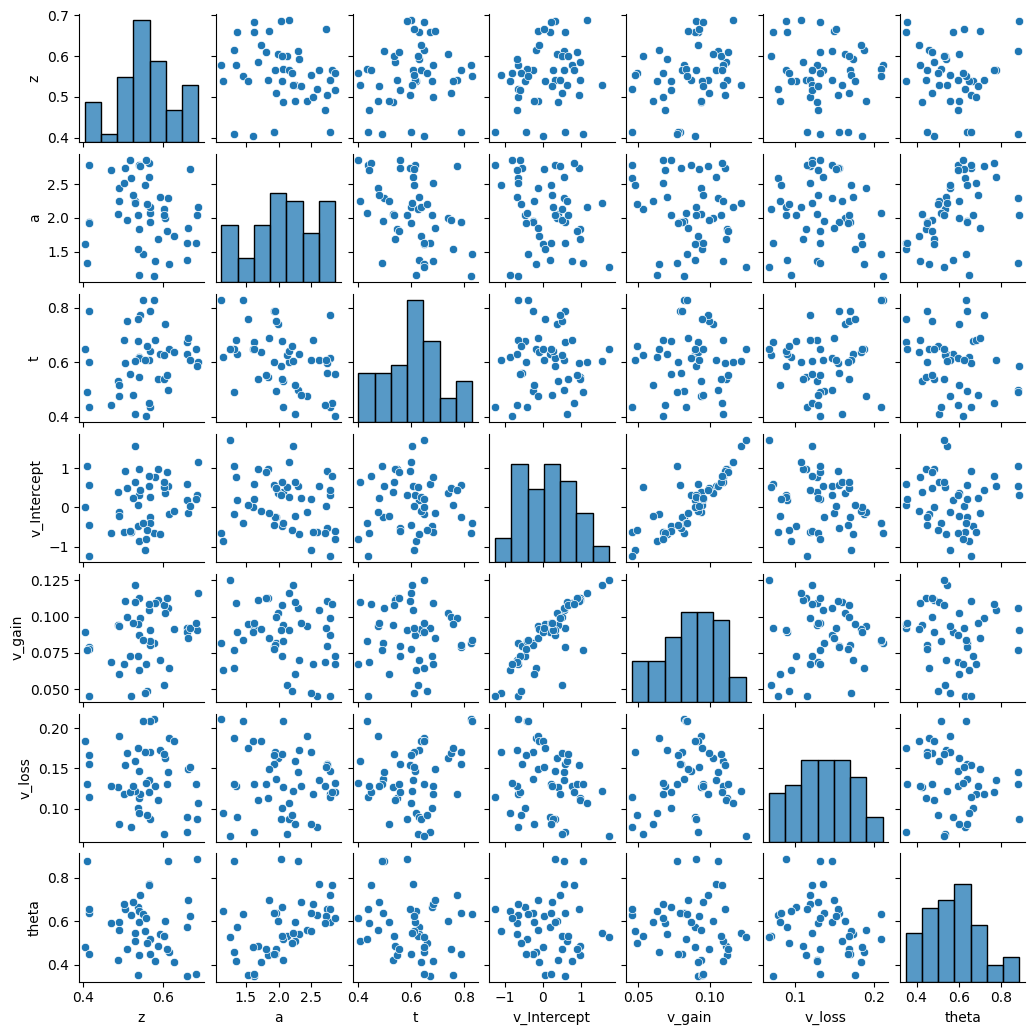

In [39]:
print("Equal Indifference Condition")
equalIndiff_params = params_fit_col.query("condition == 'equalIndifference'")[["z", "a", "t", "v_Intercept", "v_gain", "v_loss", "theta"]]
sns.pairplot(equalIndiff_params, height = 1.5)
plt.show()

In [40]:
print("Equal Range Condition")
rho = equalRange_params.corr()
pval = equalRange_params.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(*rho.shape)
pval = pd.DataFrame(stats.false_discovery_control(pval, axis = None, method = "by").reshape(pval.shape), columns=pval.columns, index=pval.index)
p = pval.map(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

Equal Range Condition


param_name,z,a,t,v_Intercept,v_gain,v_loss,theta
param_name,,,,,,,
z,1.0***,0.08,-0.08,0.11,0.29,0.08,-0.02
a,0.08,1.0***,-0.34,-0.03,-0.36,-0.16,0.58***
t,-0.08,-0.34,1.0***,0.07,-0.19,-0.05,-0.39
v_Intercept,0.11,-0.03,0.07,1.0***,0.28,-0.71***,-0.04
v_gain,0.29,-0.36,-0.19,0.28,1.0***,0.16,-0.02
v_loss,0.08,-0.16,-0.05,-0.71***,0.16,1.0***,-0.1
theta,-0.02,0.58***,-0.39,-0.04,-0.02,-0.1,1.0***


In [41]:
print("Equal Indifference Condition")
rho = equalIndiff_params.corr()
pval = equalIndiff_params.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(*rho.shape)
pval = pd.DataFrame(stats.false_discovery_control(pval, axis = None, method = "by").reshape(pval.shape), columns=pval.columns, index=pval.index)
p = pval.map(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

Equal Indifference Condition


param_name,z,a,t,v_Intercept,v_gain,v_loss,theta
param_name,,,,,,,
z,1.0***,-0.17,0.16,0.19,0.28,-0.13,-0.09
a,-0.17,1.0***,-0.42*,-0.21,-0.17,-0.11,0.37
t,0.16,-0.42*,1.0***,0.01,0.01,0.17,-0.22
v_Intercept,0.19,-0.21,0.01,1.0***,0.83***,-0.24,-0.02
v_gain,0.28,-0.17,0.01,0.83***,1.0***,0.07,-0.09
v_loss,-0.13,-0.11,0.17,-0.24,0.07,1.0***,-0.18
theta,-0.09,0.37,-0.22,-0.02,-0.09,-0.18,1.0***


**Findings:**
- For Low Reward condition (equalRange), the following parameters are significantly correlated:
    - Boundary separation (a) and theta (t) [Positively correlated***]
    - Boundary separation (a) and v_gain [Negatively correlated*]
    - Boundary separation (a) and non-decision time (t) [Negatively correlated*]
    - Non-decision time (t) and theta [Negatively correlated*]
    - Fixed utility bias (v_intercept) and v_loss [Negatively correlated***]
- For High Reward condition (equalIndifference), the following parameters are significantly correlated:
    - Boundary separation (a) and theta (t) [Positively correlated*]
    - Boundary separation (a) and non-decision time (t) [Negatively correlated**]
    - Fixed utility bias (v_intercept) and v_gain [Positively correlated***]

In both conditions, higher caution (boundary) is associated to a faster collapse of the boundary (representing the need to make a decision on time).

In the low reward condition, higher caution (boundary) is associated with more utility on gains. (The more I like the gain, the more cautious I am going to be).

In both conditions, higher caution (boundary) is associated with more time for the motor system to respond (inhibition?).

In the low reward condition, higher utility to the rejection is associated to less impact of the loss on the utility. If I tend to associate high value to the rejection, losses will not impact my utility that much (probably because I am already thinking of rejecting the gamble). 

In the high reward condition, higher utility to the rejection is associated to more impact of the gain on the utility. If I tend to associate high value to the rejection, gains will make me want to accept the gamble more (probably because, since I am thinking of rejecting the gamble, I am going to associate a good deal to higher utility!) 

If I were to take a stab at interpreting this, people associate the same utility to rejection. However, the difference comes when loss aversion is present in high reward condition because people are attributing less subjective value to the gains while only a small decrease in subjective value to the losses (compared to the low reward condition). ?

**TODO:** Check if there is any differences in the correlation between parameters. 

**What neural correlates are associated with these differences in behavior across reward environment? We can first look at arousal by examining the pupil response.**
1. In a "low reward" environment, where gains and losses are equal, pupil dilation increased when accepting a gamble (as compared to rejecting it). The size difference across subjects was linked to the response bias. 
2. In a "high reward" environment, where gains have a wider range than losses, there are larger physiological responses to increasing loss. 

Then we can ask the following question:
- Is the increase in physiological response to increasing loss associated with loss averse behavior? 
    - Analyze pupil dilation as a function of loss. How does this parameter correlate with participants loss aversion (ratio of v_loss to v_gain)?
- Does pupil dilation vary based on the response bias across environments?
    - Meaning, is physiological response indexing where the decision process starts across trials? 
    - To do this, analyze pupil dilation as a function of the response. How does this parameter correlate with the participants response bias?
    - Train an HDDM where the response bias is z ~ 1 + pupil_index (across trials).
- Why are physiological responses to increasing loss larger in the high reward condition than the low reward condition?
    - I actually dont know how to approach this. Perhaps with fMRI?
- Why are gains more valued in the low reward condition than the high reward condition?
